# Importing libraries and reading the file

First of all we import the required libraries : numpy, scipy, matplotlib and pandas

Apart from that we also need to include numpy, matplotlib and scipy libraries.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

Next we read the file to store values in two lists, x and y. ```x``` stores 'time' and ```y``` stores 'ecg' colums respectively.

In [23]:
file = pd.read_csv('sam_ECG.csv')   # reading the file
x=file["time"].tolist()             # storing time in list x
y=file["ecg"].tolist()              # storing ecg values in list y

( First I had tried importing the csv file using csv library but in that I was getting errors in storing the data and had to remove the first row which stored headings 'time' and 'ecg' in the original file. In importing csv file using pandas, I need not make any modifications to the original file. )








---

# Creating a function to apply moving average filter

Now, we create a moving average filter, that takes the signal and window size as its arguments.

I have used *moving-average filter* to smooth out the graph. The values were very fluctuating very fast and also I observed the peaks were considerably above the general trend of the graph. These observations will be made more clear as the code progresses.

In [24]:
def moving_average_filter(signal, window_size):
    filtered_signal = [] # initialize array to store averages

    i=0     # counter variable
    while i < len(signal)-window_size+1 :                       # loop for moving the window across the data
        window = signal[i : i + window_size]                    # creating a window of required size
        window_average = round(sum(window) / window_size , 2)   # calculating average of teh window and rounding off
        filtered_signal.append(window_average)                  # appending the average to the created array
        i+=1
    return filtered_signal
window_size = 75 # creating a variable for window size



---
# Trying find_peaks from scipy

First I will plot a graph to show how the data looks like. As the data size is too large, I will limit the values of x to get a clear representation.

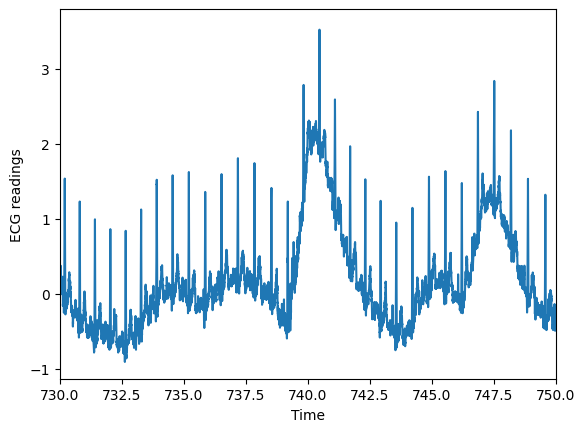

In [25]:
plt.plot(x,y)
plt.xlim(730,750)
plt.xlabel("Time")
plt.ylabel("ECG readings")
plt.show()

Now if we directly try to find peaks using ```find_peaks``` method of

```scipy``` we will find that it is very inaccurate even if we use ```height``` argument.




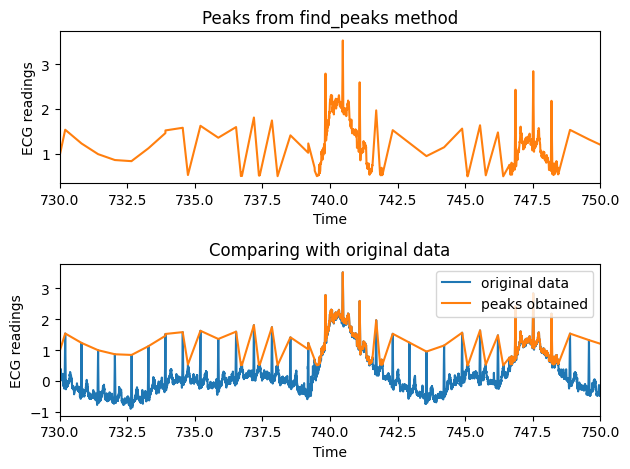

In [26]:
peak_heights = 0.5   # height for peaks
peaks = find_peaks(y,height=(peak_heights,))
peaksArr = np.asarray(peaks[0])

x_peaks = []
y_peaks = []
for i in peaksArr:
    x_peaks.append(x[i])
    y_peaks.append(y[i])

# plotting graphs
plt.subplot(2,1,1)
plt.plot(x_peaks,y_peaks,color='tab:orange')
plt.xlim(730,750)
plt.xlabel("Time")
plt.ylabel("ECG readings")
plt.title("Peaks from find_peaks method")

plt.subplot(2,1,2)
plt.plot(x,y,label='original data')
plt.plot(x_peaks,y_peaks,label='peaks obtained')
plt.xlim(730,750)
plt.xlabel("Time")
plt.ylabel("ECG readings")
plt.title("Comparing with original data")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

As can be seen from the graph, this method is very inaccurate.

So I moved on to the approach of applying the moving-average filter to smooth out the graph.



---

# Applying Moving-Average filter

Now we apply moving-average filter and store the returned data in a list named ```filter```.

The size of ```filter``` will be less than the original size by (```window_size``` - 1). So we append zeros at the end to bring it to the same size. This will not affect the required data as the data size is too large.

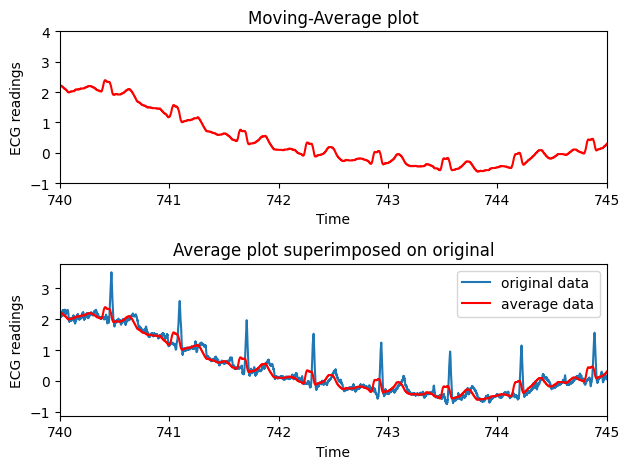

In [27]:
filter = moving_average_filter(y,window_size) # applying filter
for j in range(1,window_size):
    filter.append(0)                          # adjusting for length

# plotting graphs
plt.subplot(2,1,1)
plt.plot(x,filter,color='r')
plt.xlim(740,745)
plt.ylim(-1.0,4.0)
plt.xlabel("Time")
plt.ylabel("ECG readings")
plt.title("Moving-Average plot")

plt.subplot(2,1,2)
plt.plot(x,y,label='original data')
plt.plot(x,filter,color='r',label='average data')
plt.xlim(740,745)
plt.xlabel("Time")
plt.ylabel("ECG readings")
plt.title("Average plot superimposed on original")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

I have limited the x limits so as to give more clear comparison.

In the above plots, observe that the peaks are significantly above the average plot. This will help us in isolating the peaks from the data.

---
# Isolating the peaks
## Creating an array that stores the difference between values of original and average data :

Now we create an array named ```difference``` that stores the difference between original and average data. For this we need to convert ```y``` and ```filter``` lists into arrays, which can be done by ```asarray``` method of numpy library.

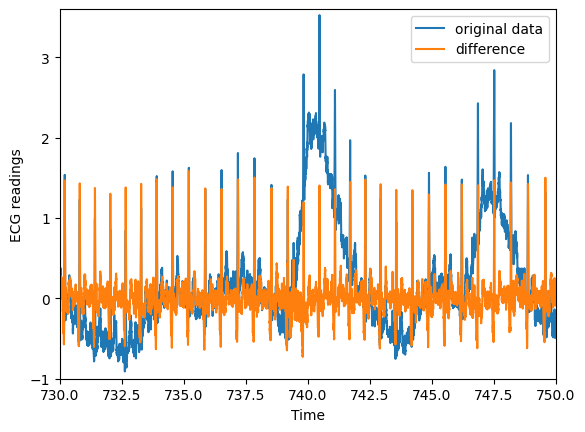

In [28]:
difference = np.asarray(y) - np.asarray(filter)

plt.plot(x,y,label='original data')
plt.plot(x,difference,label='difference')
plt.xlabel("Time")
plt.ylabel("ECG readings")
plt.xlim(730,750)
plt.ylim(-1.0,3.6)
plt.legend(loc='upper right')
plt.show()

We can see that the approach proved out to be very efficient. Wherever there was a peak in readings, there is a spike in the 'difference' plot.

We need only those indices where there is positive spike. Also it can be very easily observed from the data that all spikes have values greater than 0.8. We use this observation to proceed.


We create an array ```peak_index```. Only on those indices where there is spike will have ```true```, others will have ```False```.

Then we ensure that no two True values are consecutive in the index array, as those would correspond to same heartbeat.

After that, we take outer product of ```y``` and ```peak_index``` and store it in ```peak_values``` array. This would set all values to zero except where there is a peak.

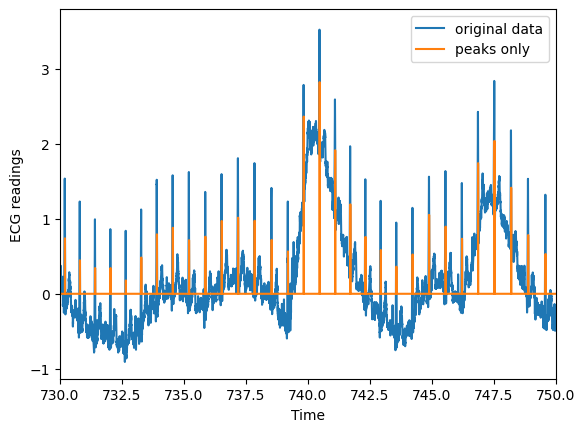

In [29]:
peak_index = difference>0.8
for t in range(len(peak_index)):
    if (peak_index[t]==True) and (peak_index[t+1]==True):
        peak_index[t] = False


peak_values = np.asarray(y) * peak_index

plt.plot(x,y,label='original data')
plt.plot(x,peak_values,label='peaks only')
plt.xlabel("Time")
plt.ylabel("ECG readings")
plt.xlim(730,750)
plt.legend(loc='upper right')
plt.show()

# Finding the heart-rate using x-coordinate of peaks

Now we need x-coordinates of peaks to find the heart rate. For that we create an empty list named ```x_peaks```. We iterate through ```peak_index``` and find the indices.

In [30]:
x_peaks = []

for k in range(len(peak_index)):
    if peak_index[k] == True:       # recording indices with only True as value in peak_index
        x_peaks.append(x[k])

Now that we have got times when there was a heartbeat recorded, we find times between consecutive heartbeats.

In [31]:
time_bw = []
for i in range(0,len(x_peaks)-1):
    time_bw.append(x_peaks[i+1] - x_peaks[i])   # list that stores time between two consecutive peaks

Now we use this array to get the hear rates of Sam at different intervals. If time between two heartbeats is ```t``` in seconds, then the heart-rate is given by ```60/t``` (in beats-per-minute).

Then we can also find the average heart-rate for the entire recording duration.

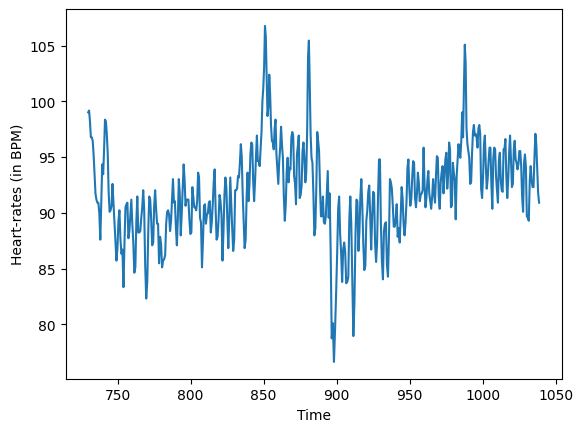

Average Heart Rate for the entire recording time :  91.934


In [32]:
heart_rates = 60/np.asarray(time_bw)

heart_rate_instants = []
for i in range(0,len(x_peaks)-1):
    heart_rate_instants.append((x_peaks[i+1] + x_peaks[i])/2)   # approximating and storing times when heart-rates are calculated by averaging the times of consecutive peaks

# plotting graph
plt.plot(heart_rate_instants,heart_rates)
plt.xlabel("Time")
plt.ylabel("Heart-rates (in BPM)")
plt.show()

avg_hr = round(sum(heart_rates)/len(heart_rates) , 3)
print("Average Heart Rate for the entire recording time : ",avg_hr)